# Fake News Detection

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

## Read Datasets

In [2]:
fake_df = pd.read_csv("data/Fake.csv")
real_df = pd.read_csv("data/True.csv")

In [3]:
fake_df.shape

(23481, 4)

In [4]:
real_df.shape

(21417, 4)

## Data Preparation

In [5]:
# Add flag to track fake and real
fake_df["target"] = "fake"
real_df["target"] = "real"

In [6]:
# Concatenate fake and real dataframes
df = pd.concat([fake_df, real_df]).reset_index(drop=True)

In [7]:
df.shape

(44898, 5)

In [8]:
# Shuffle data
from sklearn.utils import shuffle

df = shuffle(df)
df = df.reset_index(drop=True)

In [9]:
df.head()

,title,text,subject,date,target
0,'Significant gaps' in talks on Northern Irelan...,LONDON (Reuters) - Talks on restoring a power-...,worldnews,"October 30, 2017",real
1,OBAMA’S ARROGANCE: WATCH As He Admonishes Repo...,Being called out for his utter incompetence as...,politics,"Jul 15, 2015",fake
2,Turkey seeks to isolate Syria Idlib jihadists ...,ISTANBUL/BEIRUT (Reuters) - Turkey is luring m...,worldnews,"October 3, 2017",real
3,TOP 10 TWEETS From Democrat Debate,"Here s the fake black guy, Shaun King weighing...",politics,"Oct 14, 2015",fake
4,Did Hillary Clinton Seriously Criticize Berni...,"The short answer? I don t think so, but it s p...",News,"January 15, 2016",fake


In [10]:
# Remove title & date column
df.drop(["title", "date"], axis=1, inplace=True)

In [11]:
df.head()

,text,subject,target
0,LONDON (Reuters) - Talks on restoring a power-...,worldnews,real
1,Being called out for his utter incompetence as...,politics,fake
2,ISTANBUL/BEIRUT (Reuters) - Turkey is luring m...,worldnews,real
3,"Here s the fake black guy, Shaun King weighing...",politics,fake
4,"The short answer? I don t think so, but it s p...",News,fake


## Data Cleaning

In [12]:
df.dropna(subset=["text"], inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
# Convert to lowercase
df["text"] = df["text"].str.lower()

In [14]:
df.head()

,text,subject,target
0,london (reuters) - talks on restoring a power-...,worldnews,real
1,being called out for his utter incompetence as...,politics,fake
2,istanbul/beirut (reuters) - turkey is luring m...,worldnews,real
3,"here s the fake black guy, shaun king weighing...",politics,fake
4,"the short answer? i don t think so, but it s p...",News,fake


In [15]:
# Remove numbers, punctuations and extra spaces
df["text"] = df["text"].str.replace(r"[^a-zA-Z\s]", "", regex=True)
df["text"] = df["text"].str.replace(r"\s+", " ", regex=True)
df["text"] = df["text"].str.strip()

In [16]:
df.head()

,text,subject,target
0,london reuters talks on restoring a powershari...,worldnews,real
1,being called out for his utter incompetence as...,politics,fake
2,istanbulbeirut reuters turkey is luring milita...,worldnews,real
3,here s the fake black guy shaun king weighing ...,politics,fake
4,the short answer i don t think so but it s pos...,News,fake


In [17]:
# Remove stopwords
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stopwords_ = stopwords.words("english")

df["text"] = df["text"].apply(lambda x: " ".join([word for word in x.split() if word not in stopwords_]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kdnin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
df.head()

,text,subject,target
0,london reuters talks restoring powersharing go...,worldnews,real
1,called utter incompetence leader press somethi...,politics,fake
2,istanbulbeirut reuters turkey luring militants...,worldnews,real
3,fake black guy shaun king weighing awesome ber...,politics,fake
4,short answer think possiblethe day morning joe...,News,fake


## Basic Data Exploration

In [19]:
# How many articles per subject?
articles_subject_count = df.groupby(["subject"])["text"] \
    .count() \
    .sort_values(ascending=False)

In [20]:
articles_subject_count

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: text, dtype: int64

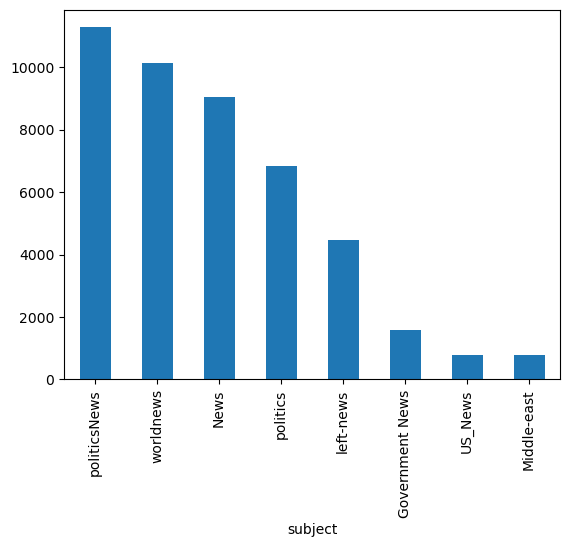

In [21]:
articles_subject_count.plot(kind="bar")
plt.show()

In [22]:
# How many fake and real articles?
articles_types_count = df.groupby(["target"])["text"].count()

In [23]:
articles_types_count

target
fake    23481
real    21417
Name: text, dtype: int64

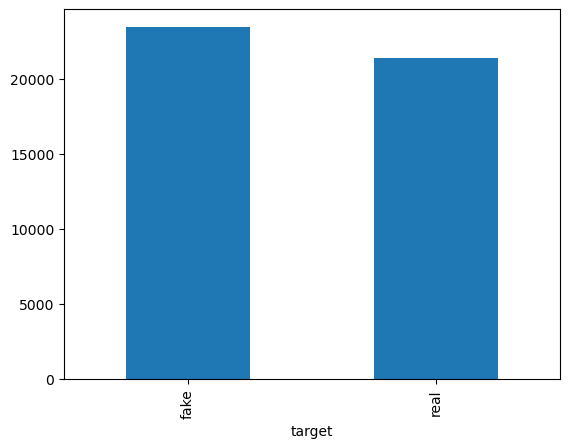

In [24]:
articles_types_count.plot(kind="bar")
plt.show()

In [25]:
from wordcloud import WordCloud


def show_wordcloud(text):
    wordcloud = WordCloud(
        width=800,
        height=500,
        max_font_size=110,
        collocations=False
    ).generate(text)

    plt.figure(figsize=(7.4, 6.4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [26]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)
import nltk
import seaborn as sns
from nltk.tokenize import WhitespaceTokenizer


def show_frequent_words(text, quantity):
    tokens = WhitespaceTokenizer().tokenize(text)
    frequency = nltk.FreqDist(tokens)

    frequency_df = pd.DataFrame(
        data=frequency.items(),
        columns=["Word", "Frequency"]
    )
    frequency_df = frequency_df.nlargest(columns="Frequency", n=quantity)

    plt.figure(figsize=(6.4, 4.8))
    ax = sns.barplot(data=frequency_df, x="Word", y="Frequency", color="blue")
    ax.set(ylabel="Count")
    plt.xticks(rotation="vertical")
    plt.show()

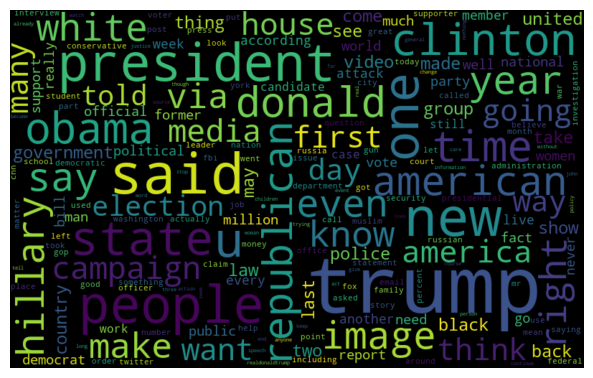

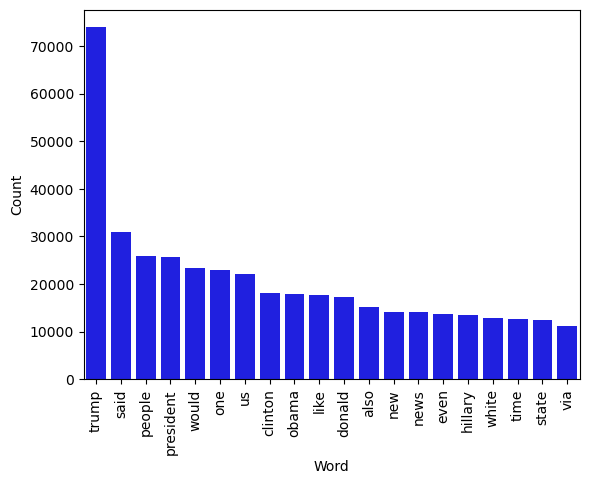

In [27]:
# Word cloud and most frequent words for fake news
text = " ".join(df[df["target"] == "fake"]["text"].to_list())

show_wordcloud(text)
show_frequent_words(text, 20)

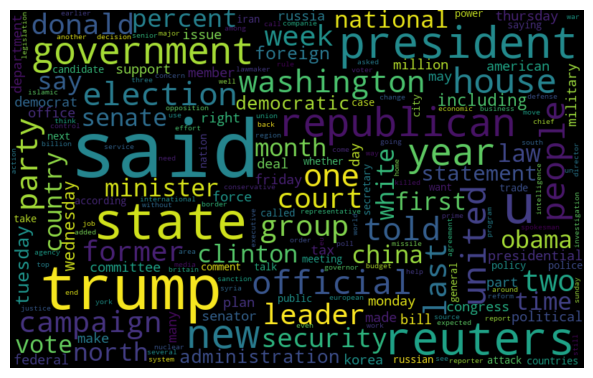

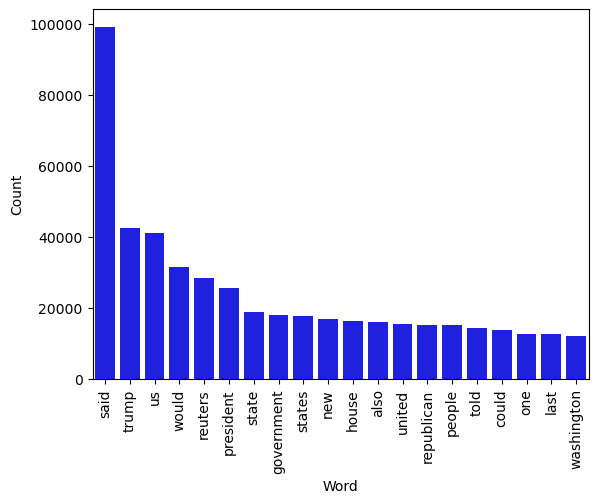

In [28]:
# Word cloud and most frequent words for real news
text = " ".join(df[df["target"] == "real"]["text"].to_list())

show_wordcloud(text)
show_frequent_words(text, 20)

## Modeling

In [29]:
# Vectorizing and applying TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline


def generate_model(model, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ("vectorizer", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("model", model)
    ])

    # Fitting the model
    model = pipeline.fit(X_train, y_train)

    # Checking accuracy
    y_pred = model.predict(X_test)
    print("Accuracy: {}%".format(round(accuracy_score(y_test, y_pred) * 100, 2)))

    # Plotting confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        normalize=None,
        display_labels=["Fake", "Real"],
        cmap=plt.cm.Blues
    )
    disp.ax_.set_title("Confusion matrix, without normalization")

### Peparing the data

In [30]:
# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["text"], df.target, test_size=0.2, random_state=42)

### Logistic Regression

Accuracy: 99.04%


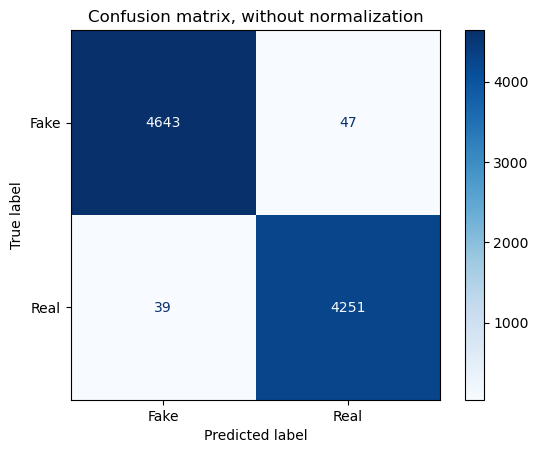

In [31]:
from sklearn.linear_model import LogisticRegression

generate_model(
    LogisticRegression(),
    X_train, X_test, y_train, y_test
)

### Decision Tree Classifier

Accuracy: 99.61%


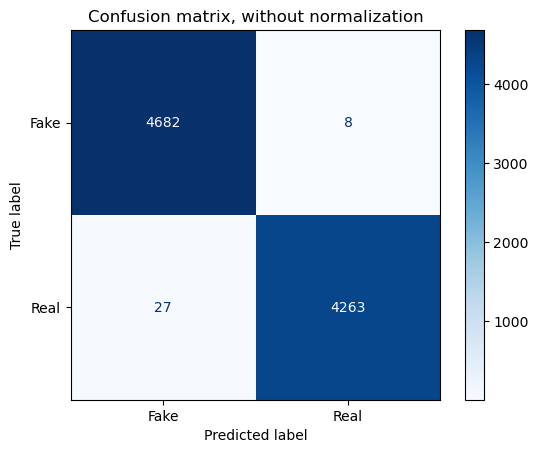

In [32]:
from sklearn.tree import DecisionTreeClassifier

generate_model(
    DecisionTreeClassifier(
        criterion="entropy",
        max_depth=20,
        splitter="best",
        random_state=42
    ),
    X_train, X_test, y_train, y_test
)

### Random Forest Classifier

Accuracy: 98.93%


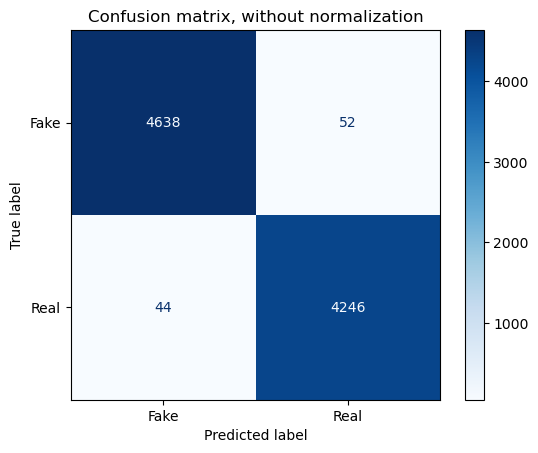

In [33]:
from sklearn.ensemble import RandomForestClassifier

generate_model(
    RandomForestClassifier(
        n_estimators=50,
        criterion="entropy"
    ),
    X_train, X_test, y_train, y_test
)